<a href="https://colab.research.google.com/github/YaoYinYing/low-n-protein-engineering/blob/master/Low_N_engineering_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Install softwares
import os
import glob
import pathlib
import sys
import time
import traceback
import pickle
import re
from IPython.utils import io
import subprocess
import tqdm.notebook
import urllib3
import gzip


try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

JAX_UNIREP_REPO='https://github.com/ElArkk/jax-unirep.git'
DOWNLOAD_PFAM_SCRIPT='https://raw.githubusercontent.com/xqding/PEVAE_Paper/master/pfam_msa/script/download_MSA.py'
ENTREZ_URL='ftp://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect//install-edirect.sh'

ROOT_DIR='.'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_BLAST=f"{RES_DIR}/MSA/blast"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'
pathes=['/usr/local/cuda-11.4/bin']
libpathes=['/usr/local/cuda-11.4/lib64']

CONDA_PATH='/opt/anaconda3'

# if not already installed
total = 3
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for dir in [ROOT_DIR,
              TMP_DIR,FLAG_DIR,WEIGHTS_DIR,SCRIPTS_DIR,
              JOBS_DIR,
              RES_DIR,RES_DIR_MSA,RES_DIR_BLAST,RES_DIR_FITNESS,RES_DIR_SEQ_OUT,RES_DIR_PICKLE,RES_DIR_REPORT,RES_DIR_FEATURE,RES_DIR_FIGURE]:
    os.makedirs(dir, exist_ok=True)
  pbar.update(1)

  for path in pathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['PATH']:
      os.environ['PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['PATH']}"
  '''
  for path in libpathes:
    if f"{pathlib.Path(path).resolve()}" not in os.environ['LD_LIBRARY_PATH']:
      os.environ['LD_LIBRARY_PATH'] = f"{pathlib.Path(path).resolve()}:{os.environ['LD_LIBRARY_PATH'] }"
  '''
  pbar.update(1)


  # weights
  #os.system(f'if [ ! -f {FLAG_DIR}/WEIGHT_READY ]; then cd {WEIGHTS_DIR}; for i in 1900_weights/ 256_weights/ 64_weights/ 1900_weights_random/ 256_weights_random/ 64_weights_random/ evotuned/unirep/ evotuned/random_init/; do echo $i; aws s3 sync --no-sign-request s3://unirep-public/$i $i; done;touch {pathlib.Path(FLAG_DIR).resolve()}/WEIGHT_READY;fi')
  pbar.update(1)
  

  0%|          | 0/3 [elapsed: 00:00 remaining: ?]

In [ ]:
#@title Goto GPU part if all data were collected.

In [4]:
#@title GPU PART!
'''
! cp -r /gdrive/MyDrive/low-n-data/* .


ROOT_DIR='.'
TMP_DIR = f"{ROOT_DIR}/tmp"

SCRIPTS_DIR=f'{TMP_DIR}/scripts'
FLAG_DIR=f'{TMP_DIR}/flag'
WEIGHTS_DIR=f'{TMP_DIR}/weights'

JOBS_DIR=f'{ROOT_DIR}/jobs'

RES_DIR=f'{ROOT_DIR}/results'
RES_DIR_MSA=f"{RES_DIR}/MSA"
RES_DIR_FITNESS=f"{RES_DIR}/fitness"
RES_DIR_SEQ_OUT=f"{RES_DIR}/sequence_out"
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'
'''

target_fasta = f'{JOBS_DIR}/890.fasta'
target_fasta=pathlib.Path(target_fasta).resolve()
job_name=target_fasta.name


In [ ]:
#@title Fetching P450 data(210 MB for InterPro ?Did we fetch all the data?)

P450_FASTA_URL="./data/IPR001128.fasta.tar.bz2"
os.system(f'cp {P450_FASTA_URL} {RES_DIR_MSA}')
os.system(f'cd {RES_DIR_MSA}; tar xjvf IPR001128.fasta.tar.bz2; mv IPR001128.fasta.tar.bz2 ..')


P450_TARGET_URL='./data/890.fasta'
os.system(f'cp {P450_TARGET_URL}  {JOBS_DIR}')

P450_BLAST_RES_URL='./data/blast_res_890.fasta.tar.bz2'
os.system(f'cp  {P450_BLAST_RES_URL} {RES_DIR_MSA} && cd {RES_DIR_MSA} &&  tar xvjf blast_res_890.fasta.tar.bz2')


P450_EXPERI_DATA_URL='./data/P450_experi_data_encoded.csv'
os.system(f'cp {P450_EXPERI_DATA_URL}  {RES_DIR_FITNESS}' )

In [5]:
#@title Generate Inputs for Evotuning eUniRep for P450 family
# https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/pre-evotuning/generate_evotune_inputs_2MS2.ipynb

from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

In [6]:
 # Functions:

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    # Yinying edited here bcs pfam provides stockholm formated file. 
    # PFam use stockholm while InterPro use fasta
    
    fasta_seqs = SeqIO.parse(open( name ), name.suffix.replace(".",''))
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open(f'{RES_DIR_SEQ_OUT}/{name}_out.fasta', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped due to length >', k, ':', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of invalid sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of valid sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    print("Mean Levenstein distance:", mean_dist)
    print("Median Levenstein distance:", mean_dist)
    print("Min Levenstein distance:", min_dist)
    print("Max Levenstein distance:", max_dist)

    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances



"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open('outputs/' + name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')

In [7]:
!echo $CONDA_PREFIX

/opt/anaconda3


In [ ]:
#@title Read protein family and clean the data for evotuning.
import glob


# input FASTA files:
in_fastas = [pathlib.Path(x).resolve() for x in glob.glob(f"{RES_DIR_MSA}/*") if x.endswith('.fasta')]

# put sequences into a pandas dataframes
sequences_df = pd.concat([pd.DataFrame(read_fasta(in_fastas[i]), columns = ['name', 'sequence']) for i in range(len(in_fastas))], axis=0).reset_index().drop('index', axis=1)

print('Total number of input sequences:', len(sequences_df))

# clean the sequences:
# the number here is the AA length we want - set to 350
clean_seqs_df = clean(sequences_df, 600)

# save clean sequences as a .fasta.txt file
write_fasta('P450_all_sequences_clean', clean_seqs_df)

In [ ]:
#@title Check P450 sequences
sequences_df.head()

In [8]:
#@title load target sequence

targets = read_fasta(target_fasta)
print(targets[0][0])
print(targets[0][1])

NP_001289636.1
MWTILLGLATLAIAYYIHWVNKWKDSKFNGVLPPGTMGLPLIGETIQLSRPSDSLDVHPFIQRKVKRYGPIFKTCLAGRPVVVSTDAEFNHYIMLQEGRAVEMWYLDTLSKFFGLDTEWLKALGLIHKYIRSITLNHFGAESLRERFLPRIEESARETLHYWSTQTSVEVKESAAAMVFRTSIVKMFSEDSSKLLTEGLTKKFTGLLGGFLTLPLNLPGTTYHKCIKDMKQIQKKLKDILEERLAKGVKIDEDFLGQAIKDKESQQFISEEFIIQLLFSISFASFESISTTLTLILNFLADHPDVVKELEAEHEAIRKARADPDGPITWEEYKSMNFTLNVICETLRLGSVTPALLRKTTKEIQIKGYTIPEGWTVMLVTASRHRDPEVYKDPDTFNPWRWKELDSITIQKNFMPFGGGLRHCAGAEYSKVYLCTFLHILFTKYRWRKLKGGKIARAHILRFEDGLYVNFTPKE


In [ ]:
#@title calculate levenstein distance from chosen target sequence
distances = lev_dist(targets[0][1], clean_seqs_df, 30, (0,300))

In [ ]:
#@title partition into the training and 2 validation sets:

clean_seqs_df_copy = clean_seqs_df.copy()
out_domain_val_set = clean_seqs_df_copy.sample(frac=0.1, weights=distances**4, random_state=17)
remainder_df = clean_seqs_df_copy.drop(out_domain_val_set.index)
#train_set = remainder_df.sample(frac=0.889, random_state=17)
#in_domain_val_set = remainder_df.drop(train_set.index)

# set check sizes and levenstein distances
print('Out of domain validation set size:', len(out_domain_val_set))
out_dom_distances = lev_dist(targets[0][1], out_domain_val_set.reset_index().drop('index', axis=1), 30, (0,300))

#print('In domain validation set size:', len(in_domain_val_set))

print('Training set size:', len(remainder_df))
training_distances = lev_dist(targets[0][1], remainder_df.reset_index().drop('index', axis=1), 30, (0,300))

In [ ]:
#@title save to fasta file formats:

write_fasta(f'{job_name}_train_set', remainder_df.reset_index().drop('index', axis=1))
write_fasta(f'{job_name}_out_domain_val_set', out_domain_val_set.reset_index().drop('index', axis=1))
#write_fasta('in_domain_val_set', in_domain_val_set.reset_index().drop('index', axis=1))

In [6]:
#@title Evotuning
# https://github.com/ElArkk/jax-unirep/blob/master/examples/evotuning.py
"""Evotuning two ways!"""

from pathlib import Path

from jax.random import PRNGKey

from jax_unirep import evotune
from jax_unirep.evotuning_models import mlstm1900
from jax_unirep.utils import dump_params
from jax_unirep.utils import load_params
from functools import partial

# Test sequences:
sequences = [x[1] for x in read_fasta(Path(f'{RES_DIR_SEQ_OUT}/{job_name}_train_set_out.fasta'))]
holdout_sequences = [x[1] for x in read_fasta(Path(f'{RES_DIR_SEQ_OUT}/{job_name}_out_domain_val_set_out.fasta'))]


# The input_shape is always going to be (-1, 26),
# because that is the number of unique AA, one-hot encoded.


n_epochs_config = {"low": 1, "high": 1}
lr_config = {"low": 1e-5, "high": 1e-3}

EVOTUNING_PROJECT=[
    "evotuning_P450_from_global",
    "evotuning_P450_from_randinit",
]


for PROJECT_NAME in EVOTUNING_PROJECT:
    #PROJECT_NAME = "evotuning_P450" #@param {type:"string"}
    init_fun, apply_fun = mlstm1900()
    
    if PROJECT_NAME.endswith("randinit"): 
        _, inital_params = init_fun(PRNGKey(42), input_shape=(-1, 26))
    else:
        inital_params=None
    # 1. Evotuning with Optuna

    study, evotuned_params = evotune(
        sequences=sequences,
        model_func=apply_fun,
        params=inital_params,
        out_dom_seqs=holdout_sequences,
        n_trials=2,
        n_splits=2,
        n_epochs_config=n_epochs_config,
        learning_rate_config=lr_config,
    )
    
    dump_params(evotuned_params, Path(f'{RES_DIR_FEATURE}/{PROJECT_NAME}'))
    print(f"Evotuning done! Find output weights in {RES_DIR_FEATURE}/{PROJECT_NAME}")
    print(study.trials_dataframe())

[I 2021-10-23 12:45:14,115] A new study created in memory with name: no-name-730488c6-8f93-4573-83df-df2dda02d431


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.2104906141757965. 


created directory at temp


  0%|          | 0/573 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.20952515304088593. 


  0%|          | 0/575 [00:00<?, ?it/s]

[I 2021-10-24 08:53:10,047] Trial 0 finished with value: 0.1068151444196701 and parameters: {'n_epochs': 1.0, 'learning_rate': 9.587014351589458e-05}. Best is trial 0 with value: 0.1068151444196701.
INFO:evotuning:Trying out 1.0 epochs with learning rate 0.00018043584194569903.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21503762900829315. 


  0%|          | 0/574 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21832290291786194. 


  0%|          | 0/573 [00:00<?, ?it/s]

[I 2021-10-24 23:31:23,581] Trial 1 finished with value: 0.09768655896186829 and parameters: {'n_epochs': 1.0, 'learning_rate': 0.00018043584194569903}. Best is trial 1 with value: 0.09768655896186829.
INFO:evotuning:Optuna done, starting tuning with learning rate=0.00018043584194569903, 


right-padding sequences:   0%|          | 0/343854 [00:00<?, ?it/s]

right-padding sequences:   0%|          | 0/38206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/13754 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21258291602134705. 
INFO:evotuning:Calculations for holdout set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.21838925778865814. 


created directory at results/feature/evotuning_P450_from_global
Evotuning done! Find output weights in ./results/feature/evotuning_P450_from_global
   number     value             datetime_start          datetime_complete  \
0       0  0.106815 2021-10-23 12:45:14.203622 2021-10-24 08:53:10.046549   
1       1  0.097687 2021-10-24 08:53:10.052687 2021-10-24 23:31:23.580790   

                duration  params_learning_rate  params_n_epochs     state  
0 0 days 20:07:55.842927              0.000096              1.0  COMPLETE  
1 0 days 14:38:13.528103              0.000180              1.0  COMPLETE  


[I 2021-10-25 03:13:35,200] A new study created in memory with name: no-name-cd46c256-8f0d-4a4b-8498-54c28bf618dd
INFO:evotuning:Trying out 1.0 epochs with learning rate 0.00022990855334515935.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.1677255779504776. 


  0%|          | 0/572 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16771169006824493. 


  0%|          | 0/575 [00:00<?, ?it/s]

[I 2021-10-25 16:44:40,403] Trial 0 finished with value: 0.15144959092140198 and parameters: {'n_epochs': 1.0, 'learning_rate': 0.00022990855334515935}. Best is trial 0 with value: 0.15144959092140198.
INFO:evotuning:Trying out 1.0 epochs with learning rate 2.057544821566471e-05.
INFO:evotuning:Split #0


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16772596538066864. 


  0%|          | 0/574 [00:00<?, ?it/s]

INFO:evotuning:Split #1


right-padding sequences:   0%|          | 0/171927 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/6877 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16772451996803284. 


  0%|          | 0/574 [00:00<?, ?it/s]

[I 2021-10-26 06:42:02,863] Trial 1 finished with value: 0.15436682105064392 and parameters: {'n_epochs': 1.0, 'learning_rate': 2.057544821566471e-05}. Best is trial 0 with value: 0.15144959092140198.
INFO:evotuning:Optuna done, starting tuning with learning rate=0.00022990855334515935, 


right-padding sequences:   0%|          | 0/343854 [00:00<?, ?it/s]

right-padding sequences:   0%|          | 0/38206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:evotuning:Random batching done: All sequences padded to max sequence length of 600


Iteration:   0%|          | 0/13754 [00:00<?, ?it/s]

INFO:evotuning:Calculations for training set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.16773498058319092. 
INFO:evotuning:Calculations for holdout set:
INFO:evotuning:Epoch 0: Estimated average loss: 0.167735755443573. 


created directory at results/feature/evotuning_P450_from_randinit
Evotuning done! Find output weights in ./results/feature/evotuning_P450_from_randinit
   number     value             datetime_start          datetime_complete  \
0       0  0.151450 2021-10-25 03:13:35.205015 2021-10-25 16:44:40.402746   
1       1  0.154367 2021-10-25 16:44:40.411932 2021-10-26 06:42:02.862593   

                duration  params_learning_rate  params_n_epochs     state  
0 0 days 13:31:05.197731              0.000230              1.0  COMPLETE  
1 0 days 13:57:22.450661              0.000021              1.0  COMPLETE  


In [9]:
#@title Top Training w/ fitness data

from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params
from Bio import SeqIO
import pandas as pd
import glob
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather


def read_labeled_data(fitness_csv,seq_col,fit_col): 
  df=pd.read_csv(pathlib.Path(fitness_csv),usecols=[seq_col,fit_col])
  data = []
  for seq, fitness in zip(df.loc[:, seq_col], df.loc[:, fit_col]):
        data.append([str(seq).strip(), fitness])
  return data
# data=read_labeled_data("./P450_experi_data_encoded.csv",'Seq','11H-Cuol')


# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	#A is the one who works with the distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

In [10]:
#@title  load labeled training data
col_seq='Seq' #@param {type:"string"}
col_fitness='11H-Cuol' #@param {type:"string"}
seqs_df = pd.DataFrame(read_labeled_data(f"{RES_DIR_FITNESS}/P450_experi_data_encoded.csv",col_seq,col_fitness), columns = ['sequence', 'fitness'])

In [11]:
# read P450 890 sequence
target_sequence=read_fasta(target_fasta)[0][1]
target_sequence

'MWTILLGLATLAIAYYIHWVNKWKDSKFNGVLPPGTMGLPLIGETIQLSRPSDSLDVHPFIQRKVKRYGPIFKTCLAGRPVVVSTDAEFNHYIMLQEGRAVEMWYLDTLSKFFGLDTEWLKALGLIHKYIRSITLNHFGAESLRERFLPRIEESARETLHYWSTQTSVEVKESAAAMVFRTSIVKMFSEDSSKLLTEGLTKKFTGLLGGFLTLPLNLPGTTYHKCIKDMKQIQKKLKDILEERLAKGVKIDEDFLGQAIKDKESQQFISEEFIIQLLFSISFASFESISTTLTLILNFLADHPDVVKELEAEHEAIRKARADPDGPITWEEYKSMNFTLNVICETLRLGSVTPALLRKTTKEIQIKGYTIPEGWTVMLVTASRHRDPEVYKDPDTFNPWRWKELDSITIQKNFMPFGGGLRHCAGAEYSKVYLCTFLHILFTKYRWRKLKGGKIARAHILRFEDGLYVNFTPKE'

In [13]:
#@title **[WIP]**  define key params ???
PROJECT_NAME='evotuning_P450_from'

gdrive_path=f'{RES_DIR_PICKLE}/'
DIR_PATH = f'{RES_DIR_FEATURE}/{PROJECT_NAME}'
#os.system(f'mkdir -p {pathlib.Path(DIR_PATH).resolve()}')

PARAMS = [ '_global/iter_0','_randinit/iter_0',None, 'one_hot',]

# get representations of data for each params:
N_seqs = len(seqs_df)
print("N_seqs:", N_seqs)

# vary batches based on memory available (i.e. if you have less memory run more batches)
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 6

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

for param in PARAMS:
  # append path to param unless unirep (no param)
  if param == 'one_hot':
    print('getting reps for one hot')
    onehot = multi_onehot(seqs_df.sequence)
    feat_cols = [ 'feat' + str(j) for j in range(1, onehot.shape[1] + 1) ]
    this_df = pd.DataFrame(onehot, columns=feat_cols)
    this_df.insert(0, "sequence", seqs_df.sequence)
    this_df.insert(1, "fitness", seqs_df.fitness)

    save_reps(this_df, gdrive_path + 'one_hot')

    continue

  elif param is None:
    name = 'unirep'

  else:
    name = f'{PROJECT_NAME}-{param}'.replace("/",'_')
    # param is the second element of returned tuple
    # fixed by Yinying
    param = load_params(DIR_PATH + param)[1]

  print('getting reps for', name)
  #print(param)
  # get 1st sequence
  reps, _, _ = get_reps(seqs_df.sequence[0], params=param)
  feat_cols = [ 'feat' + str(j) for j in range(1, reps.shape[1] + 1) ]
  this_df = pd.DataFrame(reps, columns=feat_cols)
  this_df.insert(0, "sequence", seqs_df.sequence[0])
  this_df.insert(1, "fitness", seqs_df.fitness[0])

  # get the rest in batches
  for i in range(N_BATCHES):
    this_unirep, _, _ = get_reps(seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] , params=param)
    this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
    this_unirep_df.insert(0, "sequence", seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_unirep_df.insert(1, "fitness", seqs_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_df = pd.concat([this_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

  save_reps(this_df, gdrive_path + name)

N_seqs: 84
getting reps for evotuning_P450_from-_global_iter_0
./results/pickle/evotuning_P450_from-_global_iter_0.feather saved!
getting reps for evotuning_P450_from-_randinit_iter_0
./results/pickle/evotuning_P450_from-_randinit_iter_0.feather saved!
getting reps for unirep
./results/pickle/unirep.feather saved!
getting reps for one hot
./results/pickle/one_hot.feather saved!


In [14]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path 

unirep_df = read_reps(FEATHER_PATH + 'unirep')
eunirep_df = read_reps(FEATHER_PATH + 'evotuning_P450_from-_global_iter_0')
rand_eunirep_df=read_reps(FEATHER_PATH + 'evotuning_P450_from-_randinit_iter_0')
onehot_df = read_reps(FEATHER_PATH + 'one_hot')

dfs = [unirep_df, eunirep_df, onehot_df,rand_eunirep_df]
df_names = ['unirep', 'eunirep', 'one hot','rand_eunirep']

  0%|          | 0/24 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

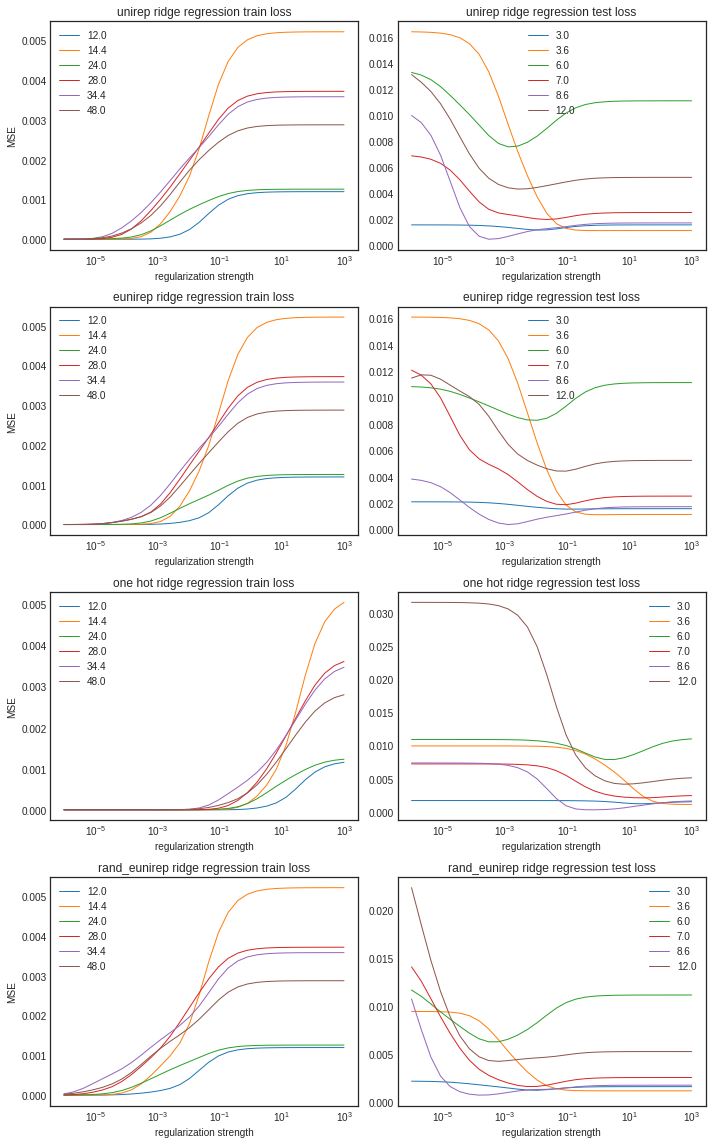

In [40]:
# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

BATCH_SIZES = [12,15,24,28,35,48]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

plt.clf()

fig = plt.figure(figsize=(10,4*len(dfs)))
plt.style.use('seaborn-white')
alpha_vals = np.logspace(-6,3,30)

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)

for i in range(len(dfs)):
    ax1 = fig.add_subplot(len(dfs),2,(2*i+1), title=df_names[i] + " ridge regression train loss")
    ax2 = fig.add_subplot(len(dfs),2,(2*i+2), title=df_names[i] + " ridge regression test loss")
    
    df = dfs[i]
    for batch_size in batch_size_list:
        pbar.update(1)
        X = df.loc[rndperm[:batch_size], df.columns[2:]]
        Y = df.loc[rndperm[:batch_size], "fitness"]

        
        alpha_list = []
        train_loss_list = []
        test_loss_list = []
        
        for alpha_i in alpha_vals:
            #print(f'df\t{i}: \tbatch_size\t{batch_size}\talpha_i\t{alpha_i}')
            
            # train-test split for both 
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # ridge regression model setup
            kfold = KFold(n_splits=10, random_state=42, shuffle=True)

            model = RidgeCV(alphas=[alpha_i], cv=kfold)

            # fit the model
            model.fit(X_train, Y_train)

            # predict fitness to get train and test losses
            Y_train_preds = model.predict(X_train)
            Y_test_preds = model.predict(X_test)

            # train_loss = np.linalg.norm(Y_train_preds - Y_train)
            # test_loss = np.linalg.norm(Y_test_preds - Y_test)
            train_loss = np.mean((Y_train_preds - Y_train)**2)
            test_loss = np.mean((Y_test_preds - Y_test)**2)

            alpha_list.append(model.alpha_)
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
        '''
        print(f'')
        print(f'alpha_list={alpha_list}')
        print(f'train_loss_list={train_loss_list}')
        print(f'test_loss_list={test_loss_list}')
        '''
        # plot train and test losses
        ax1.plot(alpha_list, train_loss_list,linewidth=1)
        ax2.plot(alpha_list, test_loss_list,linewidth=1)

    ax1.legend(batch_size_list*0.8)
    ax1.set_xscale("log")
    ax1.set_xlabel("regularization strength")
    ax1.set_ylabel("MSE")
    ax2.legend(batch_size_list*0.2)
    ax2.set_xscale("log")
    ax2.set_xlabel("regularization strength")
    ax1.set_ylabel("MSE")

plt.tight_layout()
plt.show()

  0%|          | 0/8 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

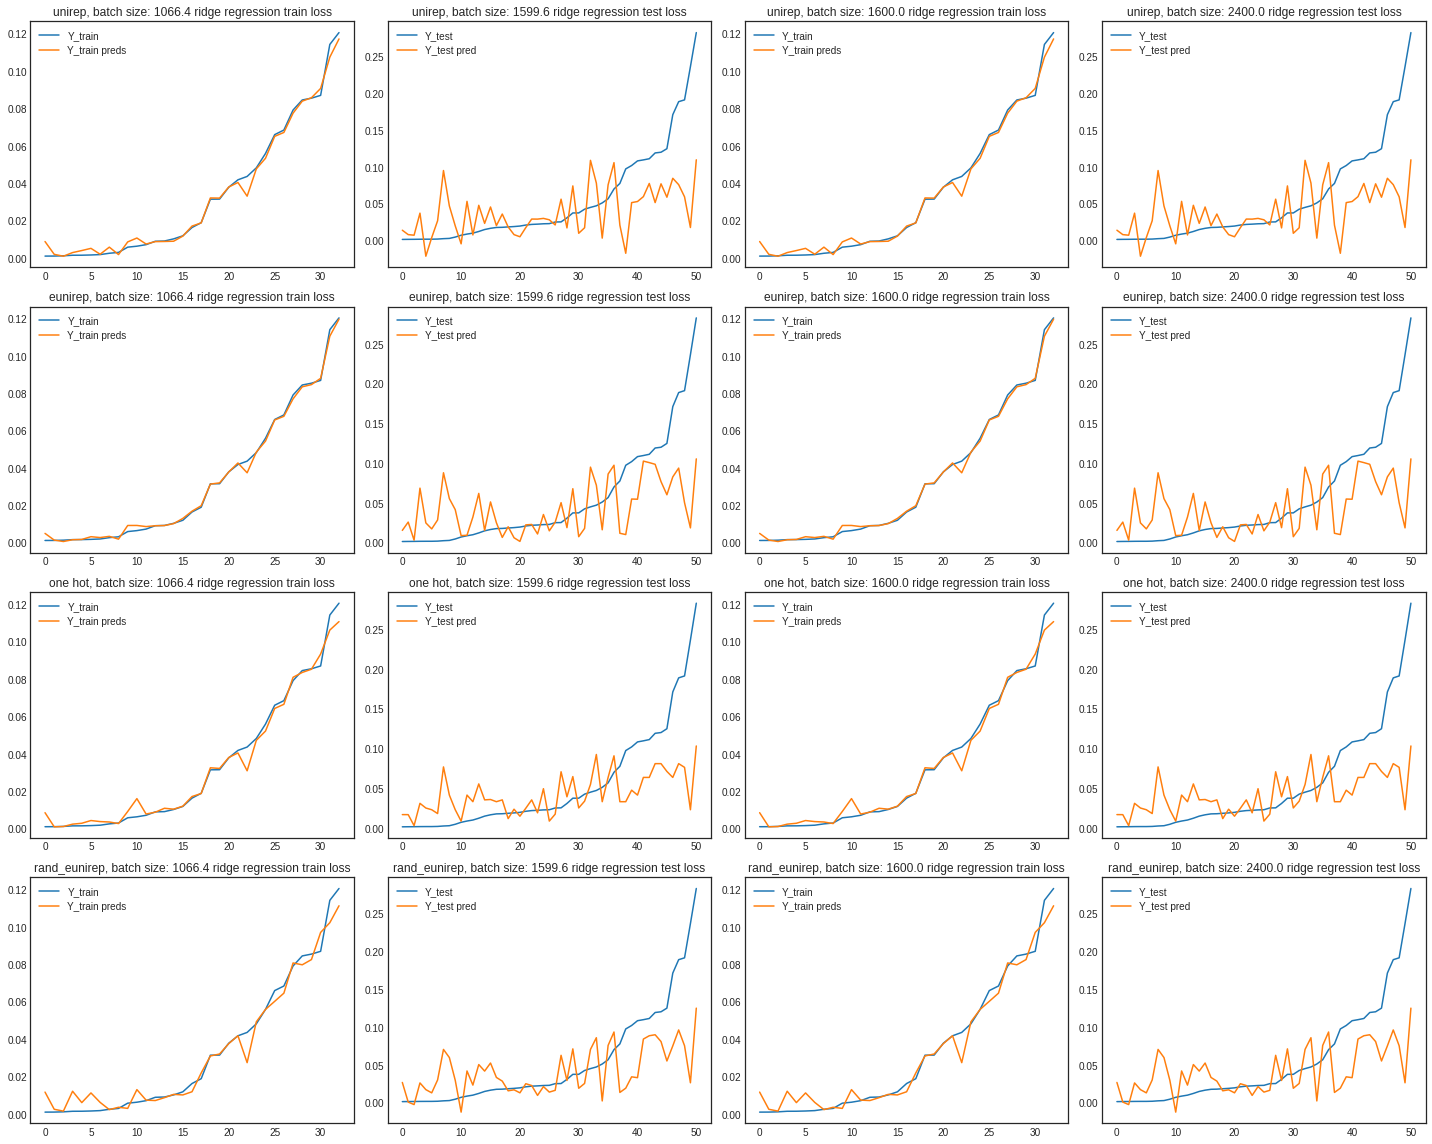

In [15]:
ALPHAS = [ 0.00005, 0.0001,0.15,0.00002]

BATCH_SIZES = [1600,2400]
SPLIT = 0.6

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)
for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):
    pbar.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = RidgeCV(alphas=[ALPHAS[i]], cv=kfold)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()

[10, 15, 20, 25, 30, 35]


  0%|          | 0/24 [elapsed: 00:00 remaining: ?]

  0%|          | 0/480 [elapsed: 00:00 remaining: ?]

  0%|          | 0/9600 [elapsed: 00:00 remaining: ?]

unirep [0.8928571428571429, 1.2121212121212122, 1.4173228346456694, 1.1940298507462686, 0.9917355371900827, 1.0687022900763359, 1.1940298507462686, 1.2030075187969924, 1.1428571428571428, 1.2307692307692308, 0.7936507936507937, 1.25, 1.4285714285714286, 1.3533834586466165, 1.2030075187969924, 1.1510791366906474, 1.0294117647058825, 1.1267605633802817, 1.5748031496062993, 1.2413793103448276] Mean Score: 1.1849739867600058
eunirep [0.5357142857142857, 1.3636363636363638, 1.4173228346456694, 1.1940298507462686, 1.322314049586777, 1.3740458015267176, 1.3432835820895521, 1.2030075187969924, 1.1428571428571428, 1.5384615384615385, 0.6349206349206349, 1.1111111111111112, 1.2857142857142858, 0.9022556390977443, 1.3533834586466165, 1.1510791366906474, 1.1764705882352942, 0.8450704225352114, 1.2598425196850394, 1.2413793103448276] Mean Score: 1.1697950037521363
one hot [0.5357142857142857, 1.2121212121212122, 1.4173228346456694, 1.1940298507462686, 1.322314049586777, 1.3740458015267176, 1.343283

rand_eunirep [1.0498687664041995, 1.1825192802056557, 1.1578947368421053, 1.2054794520547945, 1.1764705882352942, 1.1548556430446193, 1.1253196930946292, 1.0526315789473684, 1.1494252873563218, 1.105527638190955, 1.0282776349614395, 1.1224489795918366, 1.0945273631840795, 1.126005361930295, 1.0401891252955084, 1.3368983957219251, 1.25, 0.9790209790209791, 1.2030075187969924, 1.0208816705336428] Mean Score: 1.1280624846706322
unirep [0.9361702127659575, 1.0176991150442478, 1.1566265060240963, 1.1818181818181819, 1.1416490486257929, 1.1320754716981132, 1.0570824524312896, 1.0596026490066226, 1.1553784860557768, 1.2189616252821671, 1.0964912280701753, 1.1037527593818985, 1.0947368421052632, 1.2254901960784315, 1.087866108786611, 1.2315270935960592, 1.1061946902654867, 0.9900990099009901, 1.059322033898305, 1.1020408163265305] Mean Score: 1.1077292263581
eunirep [0.9787234042553191, 0.8849557522123893, 1.1566265060240963, 1.0454545454545454, 1.0147991543340382, 0.9905660377358491, 1.099365

<Figure size 432x288 with 0 Axes>

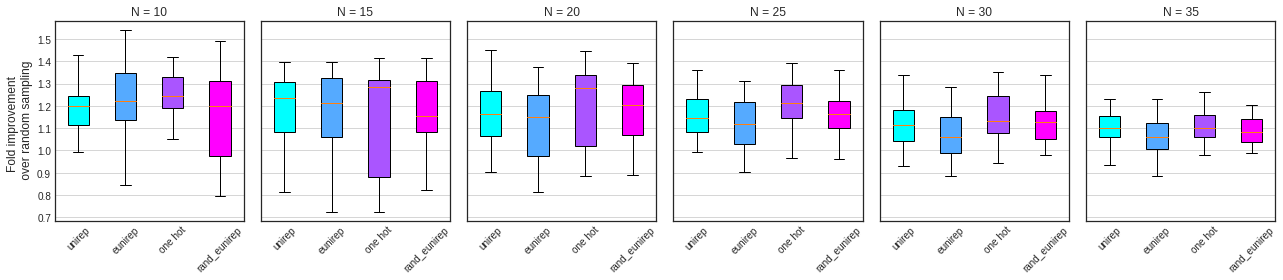

In [21]:

'''
# number of batches to test
N_BATCH = 200

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10, 15,20]

# number of random trials to perform for baseline
N_RAND_BATCHES = 100
'''


# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10,15,20,25,30,35] 
print(TRAIN_BATCH_SIZES)
# number of random trials to perform for baseline
N_RAND_BATCHES = 20

# wild-type fitness
WT_FIT = 0.0121563


total1=len(TRAIN_BATCH_SIZES)*len(dfs)
pbar1=tqdm.notebook.tqdm(total=total1, bar_format=TQDM_BAR_FORMAT)

total2=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH
pbar2=tqdm.notebook.tqdm(total=total2, bar_format=TQDM_BAR_FORMAT)

total3=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH*N_RAND_BATCHES
pbar3=tqdm.notebook.tqdm(total=total3, bar_format=TQDM_BAR_FORMAT)

batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    pbar1.update(1)
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      pbar2.update(1)
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        pbar3.update(1)
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

  0%|          | 0/8 [elapsed: 00:00 remaining: ?]

<Figure size 432x288 with 0 Axes>

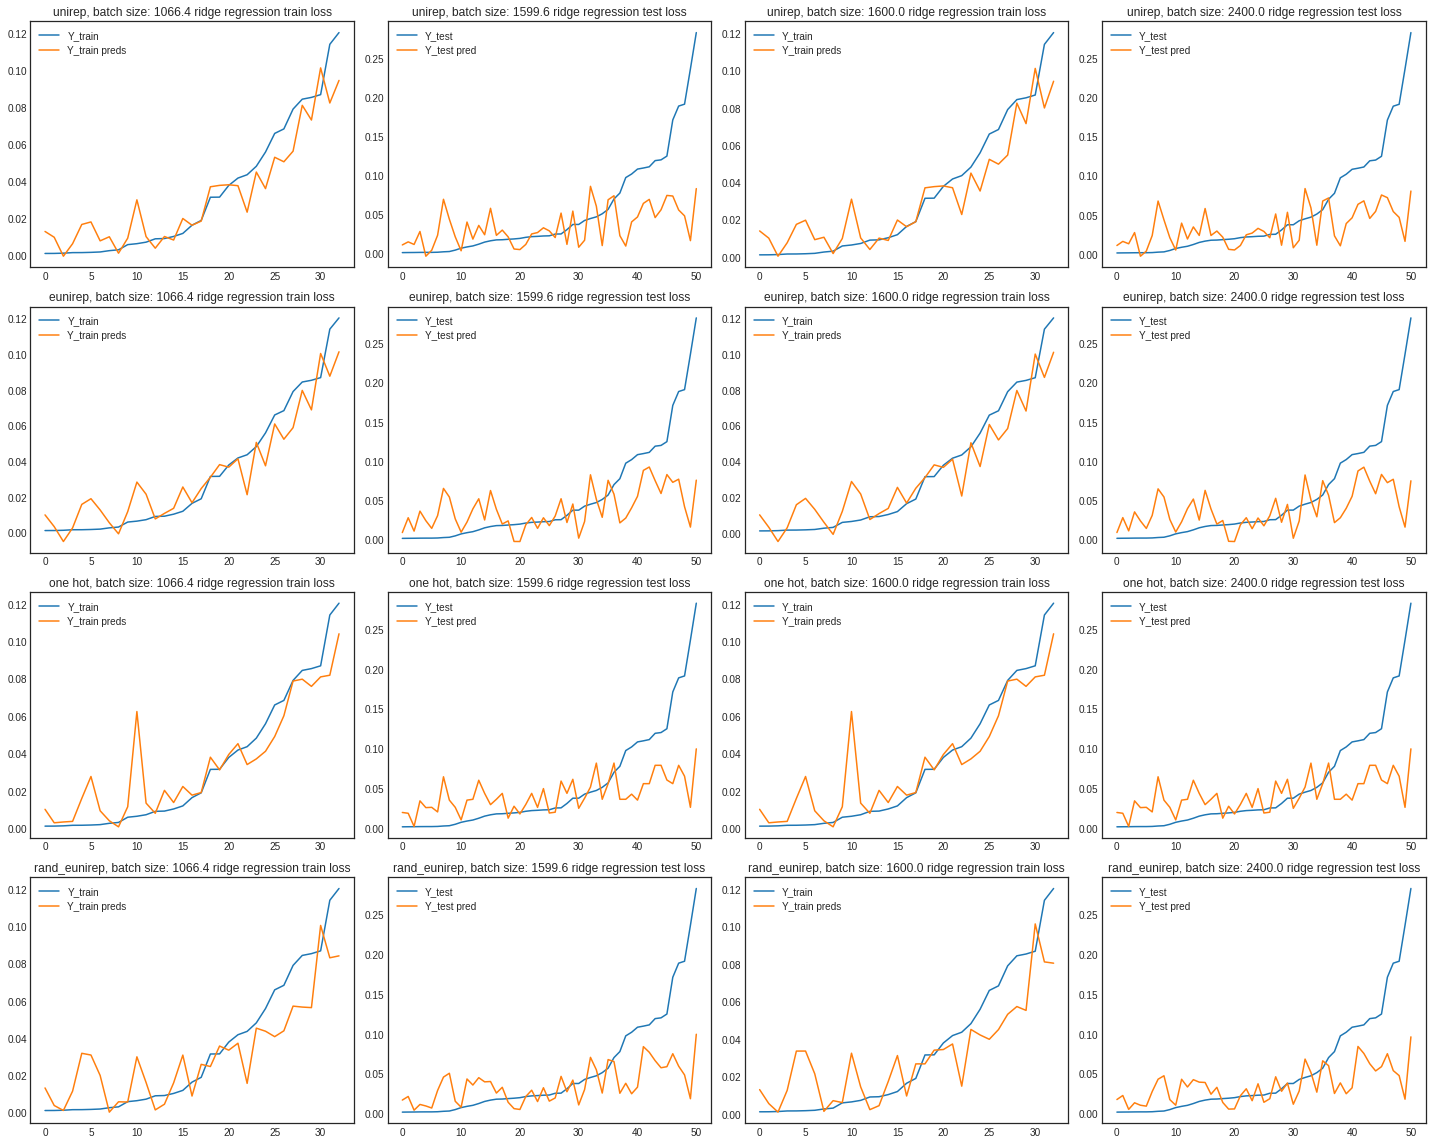

In [22]:
# Ensemble Ridge Regression
from sklearn.ensemble import BaggingRegressor

ALPHAS = [ 0.00005, 0.0001,0.15,0.00002]

BATCH_SIZES = [1600,2400]
SPLIT = 0.6

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

total=len(dfs)*len(batch_size_list)
pbar=tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT)

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):
    pbar.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = BaggingRegressor(base_estimator=RidgeCV(alphas=[ALPHAS[j]], cv=kfold), n_estimators=20, max_samples=0.9, max_features=0.9, random_state=42)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()

[10, 15, 20, 25, 30, 35]


  0%|          | 0/24 [elapsed: 00:00 remaining: ?]

  0%|          | 0/480 [elapsed: 00:00 remaining: ?]

  0%|          | 0/9600 [elapsed: 00:00 remaining: ?]

unirep [0.8928571428571429, 1.2121212121212122, 1.2598425196850394, 1.1940298507462686, 1.322314049586777, 1.0687022900763359, 1.1940298507462686, 1.2030075187969924, 1.4285714285714286, 1.2307692307692308, 1.1111111111111112, 1.25, 1.4285714285714286, 1.3533834586466165, 1.2030075187969924, 1.1510791366906474, 1.3235294117647058, 1.1267605633802817, 1.5748031496062993, 1.103448275862069] Mean Score: 1.2315969574193422
eunirep [0.5357142857142857, 1.3636363636363638, 1.2598425196850394, 1.1940298507462686, 1.15702479338843, 1.3740458015267176, 1.3432835820895521, 1.2030075187969924, 1.1428571428571428, 1.5384615384615385, 0.4761904761904762, 1.1111111111111112, 1.2857142857142858, 1.2030075187969924, 1.3533834586466165, 1.1510791366906474, 1.1764705882352942, 0.9859154929577465, 1.4173228346456694, 1.2413793103448276] Mean Score: 1.1756738805118
one hot [1.25, 1.2121212121212122, 1.4173228346456694, 1.1940298507462686, 1.322314049586777, 1.3740458015267176, 1.1940298507462686, 1.203007

unirep [0.9787234042553191, 1.0619469026548671, 1.1566265060240963, 1.1818181818181819, 1.1839323467230445, 1.1320754716981132, 1.1416490486257929, 1.1037527593818985, 1.2350597609561753, 1.2641083521444696, 1.0526315789473684, 1.1037527593818985, 1.0105263157894737, 1.1274509803921569, 1.087866108786611, 1.2315270935960592, 1.1061946902654867, 0.9900990099009901, 1.059322033898305, 1.0204081632653061] Mean Score: 1.1114735734252805
eunirep [0.9787234042553191, 0.9292035398230087, 1.108433734939759, 1.0909090909090908, 1.0570824524312896, 1.1320754716981132, 1.0993657505285412, 1.1037527593818985, 1.0756972111553784, 1.1738148984198646, 1.0526315789473684, 1.1037527593818985, 1.0105263157894737, 1.0294117647058825, 1.0460251046025104, 1.2315270935960592, 1.1061946902654867, 0.9900990099009901, 1.059322033898305, 1.1428571428571428] Mean Score: 1.076070290374369
one hot [0.9787234042553191, 1.0176991150442478, 1.0602409638554218, 1.1818181818181819, 1.0570824524312896, 1.132075471698113

<Figure size 432x288 with 0 Axes>

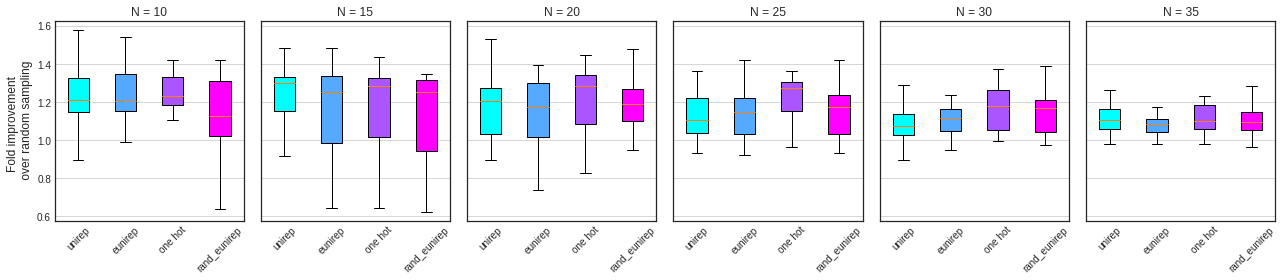

In [23]:
'''
# number of batches to test
N_BATCH = 200

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10, 15,20]

# number of random trials to perform for baseline
N_RAND_BATCHES = 100
'''

# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [10,15,20,25,30,35] 
print(TRAIN_BATCH_SIZES)
# number of random trials to perform for baseline
N_RAND_BATCHES = 20

# wild-type fitness
WT_FIT = 0.0121563



total1=len(TRAIN_BATCH_SIZES)*len(dfs)
pbar1=tqdm.notebook.tqdm(total=total1, bar_format=TQDM_BAR_FORMAT)

total2=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH
pbar2=tqdm.notebook.tqdm(total=total2, bar_format=TQDM_BAR_FORMAT)

total3=len(TRAIN_BATCH_SIZES)*len(dfs)*N_BATCH*N_RAND_BATCHES
pbar3=tqdm.notebook.tqdm(total=total3, bar_format=TQDM_BAR_FORMAT)



batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:
  
  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    pbar1.update(1)
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      pbar2.update(1)
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = BaggingRegressor(base_estimator=RidgeCV(alphas=[ALPHAS[j]], cv=kfold), n_estimators=20, max_samples=0.9, max_features=0.9, random_state=42)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        pbar3.update(1)
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

ValueError: HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH

<Figure size 432x288 with 0 Axes>

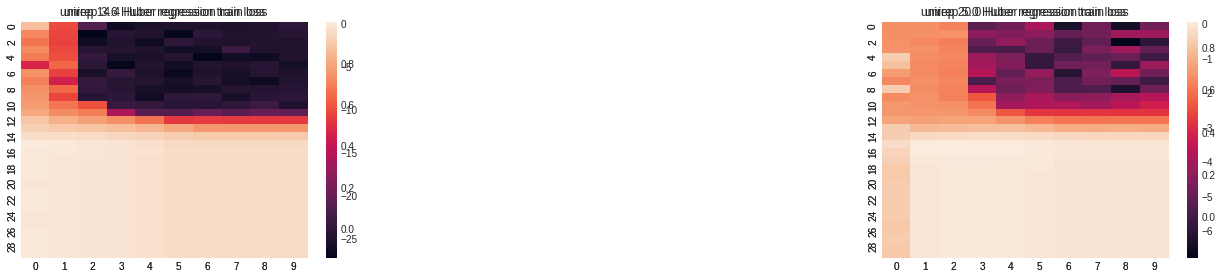

In [33]:
# HUBER LOSS
np.random.seed(42)


rndperm = np.random.permutation(unirep_df.shape[0])

BATCH_SIZES = [15,20,45]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

alpha_vals = np.logspace(-6,6,30)
eps_vals = np.linspace(1.0,5.0,10)

plt.clf()

fig = plt.figure(figsize=(45,5*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):
  #pbar1.update(1)
  df = dfs[i]
  for j in range(len(batch_size_list)):
    #pbar2.update(1)
    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]


    train_loss_mat = np.zeros((len(alpha_vals), len(eps_vals)))
    test_loss_mat = np.zeros((len(alpha_vals), len(eps_vals)))

    for k in range(len(alpha_vals)):
      #pbar3.update(1)
      for l in range(len(eps_vals)):
        #pbar4.update(1)
        # train-test split for both 
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # ridge regression model setup
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        model = HuberRegressor(epsilon=eps_vals[l], alpha=alpha_vals[k])

        # fit the model
        model.fit(X_train, Y_train)

        # predict fitness to get train and test losses and update matrices
        train_loss_mat[k,l] = model.score(X_train, Y_train)
        test_loss_mat[k,l] = model.score(X_test, Y_test)

    # plot train and test losses
    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(5*i+2*j+1), title=df_names[i] + " " + str(batch_size_list[j]*0.8) + " Huber regression train loss")
    sns.heatmap(train_loss_mat, ax=ax1)
    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(5*i+2*j+1), title=df_names[i] + " " + str(batch_size_list[j]*0.2) + " Huber regression train loss")
    sns.heatmap(test_loss_mat, ax=ax2)

plt.tight_layout()
plt.show()